# Intégrer une colonne population pour créer des features relatives à celles-ci

Grâce au CSV country_population_2020 pris de Kaggle, on rejoute pour chaque ligne une données Population qui correspond au pays.

In [1]:
import pandas as pd

##### Ajout de la population dan le DataSet #####

# Charger les données
population_df = pd.read_csv('country_population_2020.csv')
covid_df = pd.read_csv('data_etl_output.csv')

# Créer un dictionnaire de mapping pour les noms de pays qui diffèrent
country_name_mapping = {
    'Burma': 'Myanmar',
    'Congo (Brazzaville)': 'Congo',
    'Congo (Kinshasa)': 'DR Congo',
    'Czechia': 'Czech Republic (Czechia)',
    'Taiwan*': 'Taiwan',
    'US': 'United States',
    'West Bank and Gaza': 'State of Palestine',
    'Kosovo': 'Kosovo',  # Kosovo n'est pas dans le fichier population
    "Cote d'Ivoire": "Côte d'Ivoire",
    'Saint Kitts and Nevis': 'Saint Kitts & Nevis',
    'Saint Vincent and the Grenadines': 'St. Vincent & Grenadines',
    'Sao Tome and Principe': 'Sao Tome & Principe'
}

# Ajout manuel de la population du Kosovo car vide
kosovo_data = pd.DataFrame({
    'Country (or dependency)': ['Kosovo'],
    'Population (2020)': [1920079],
    'Yearly Change': [""],
    'Net Change': [""],
    'Density (P/Km²)': [""],
    'Land Area (Km²)': [""],
    'Migrants (net)': [""],
    'Fert. Rate': [""],
    'Med. Age': [""],
    'Urban Pop %': [""],
    'World Share': [""]
})

# ajoute Kosovo dans population_df
population_df = pd.concat([population_df, kosovo_data], ignore_index=True)

# Nettoyer les noms de pays dans les deux dataframes
population_df['Country'] = population_df['Country (or dependency)'].str.strip()
covid_df['Country'] = covid_df['Country'].str.strip()

# Appliquer le mapping aux noms de pays dans covid_df
covid_df['Country'] = covid_df['Country'].replace(country_name_mapping)

# Fusionner les données en gardant toutes les lignes de covid_df
final_df = pd.merge(
    covid_df,
    population_df[['Country', 'Population (2020)']],
    on='Country',
    how='left'
)

# Renommer la colonne de population
final_df.rename(columns={'Population (2020)': 'Population'}, inplace=True)

OSError: [Errno 35] Resource deadlock avoided

# Création de features par rapport à la population et au temps écoulé entre chaque mesure

On rajoute des colonnes pour avoir :
- Le taux d'infections, de morts, et de guéris pour 100K habitants sur une population d'un pays
- La tendance d'infection d'un pays (sur une période de 3 mois)
- La moyenne mobile de chaque pays


In [2]:
##### Ajoute les colonnes Confirmed_per_100K, ... pour apporter de nouvelles metrics à nos modèles #####

def calc_features(dataframe):
    dataframe["Confirmed_per_100K"] = dataframe["Confirmed"] / (dataframe["Population"] / 100000)
    dataframe["Deaths_per_100K"] = dataframe["Deaths"] / (dataframe["Population"] / 100000)
    dataframe["Recovered_per_100K"] = dataframe["Recovered"] / (dataframe["Population"] / 100000)
    
    ##### Calcul des tendances et moyennes mobiles #####
    for col in ['Confirmed', 'Deaths', 'Recovered']:
        dataframe[f'{col}_rolling_avg3'] = dataframe.groupby('Country')[col].transform(
            lambda x: x.rolling(3, min_periods=1).mean()
        )
        
        dataframe[f'{col}_trend'] = dataframe.groupby('Country')[col].transform(
            lambda x: x.diff().rolling(3, min_periods=1).mean().fillna(0)
        )

calc_features(final_df)

# Vérification et correction des données

On vérifie la cohérence de nos données.

## Population
Si une donnée est manquante on essaie d'affecter la valeur population d'une autre ligne avec le même pays.
Si elles sont toutes vides, on lance un message d'alerte.

## Features
Si on a recalculé les valeurs dans Population, alors on refait les features XXX_per_100K, ...

In [3]:
##### Vérification et correction des valeurs négatives #####
# Pour les principales métriques COVID
isNeg = False

for col in ['Confirmed', 'Deaths', 'Recovered']:
    if (sum(final_df[col] < 0) > 0):
        isNeg = True
    final_df.loc[final_df[col] < 0, col] = 0
    print(f"{sum(final_df[col] < 0)} valeurs négatives corrigées dans {col}")

##### Correction des populations manquantes par pays #####
# 1. Identifier les lignes où la population est manquante ou <= 800 (Pop Vatican)
missing_pop_mask = final_df['Population'].isna() | (final_df['Population'] <= 800)

# 2. Grouper par pays et remplir les trous avec la première valeur valide trouvée dans le même pays
final_df['Population'] = final_df.groupby('Country')['Population'].transform(
    lambda x: x.fillna(x[x.notna() & (x > 800)].iloc[0] if any(x[x.notna() & (x > 800)]) else x)
)

# 3. Vérifier ce qui reste sans population
still_missing = final_df['Population'].isna() | (final_df['Population'] <= 800)

if still_missing.any():
    missing_countries = final_df[still_missing]['Country'].unique()
    print(f"AVERTISSEMENT : Population toujours manquante pour {len(missing_countries)} pays :")
    print(', '.join(missing_countries))
    
    # Option 1 : Exclure ces pays des métriques par habitant
    for col in ['Confirmed_per_100K', 'Deaths_per_100K', 'Recovered_per_100K']:
        final_df.loc[still_missing, col] = 0
    
##### Recalculer les métriques après corrections #####
# Recalculer les indicateurs normalisés si la population a été modifiée
if missing_pop_mask.any() | isNeg :  # Changed from missing_pop to missing_pop_mask
    calc_features(final_df)

print("\nVérifications de qualité terminées. Données prêtes pour l'analyse.")

0 valeurs négatives corrigées dans Confirmed
0 valeurs négatives corrigées dans Deaths
0 valeurs négatives corrigées dans Recovered

Vérifications de qualité terminées. Données prêtes pour l'analyse.


# Entrainement des données

Split 80/20 pour les données au vu de la taille du dataset

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Créer des colonnes décalées pour les prédictions
for col in ['Confirmed', 'Deaths', 'Recovered']:
    final_df[f'{col}_lag1'] = final_df.groupby('Country')[col].shift(1).fillna(0)

# Encoder les pays
le = LabelEncoder()
final_df['Country_encoded'] = le.fit_transform(final_df['Country'])

# Définir les features et la target
features = [
    'Confirmed_lag1', 'Deaths_lag1', 'Recovered_lag1', 'Country_encoded',
    'Confirmed_per_100K', 'Deaths_per_100K', 'Recovered_per_100K',
    'Confirmed_rolling_avg3', 'Deaths_rolling_avg3', 'Recovered_rolling_avg3',
    'Confirmed_trend', 'Deaths_trend', 'Recovered_trend'
]
targets = ['Confirmed', 'Deaths', 'Recovered']

X = final_df[features]
y = final_df[targets]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création des modèles

Liste des modèles créés :
- RandomForestRegressor
- XGBoostRegressor
- Keras Tensorflow

In [5]:
from sklearn.ensemble import RandomForestRegressor

rfr_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
rfr_model.fit(X_train[features], y_train)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

In [12]:
from xgboost import XGBClassifier, XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='rmse'  # or 'mae', 'rmsle'
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [13]:
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Couche d'entrée
inputs = Input(shape=(X_train_scaled.shape[1],))

# Couches partagées
x = Dense(64, activation='relu')(inputs)
x = Dense(32, activation='relu')(x)

# Sorties nommées explicitement
output_confirmed = Dense(1, name='Confirmed')(x)
output_deaths = Dense(1, name='Deaths')(x)
output_recovered = Dense(1, name='Recovered')(x)

# Création du modèle
keras_model = Model(inputs=inputs, outputs=[output_confirmed, output_deaths, output_recovered])

# Compilation avec les noms de sortie alignés
keras_model.compile(
    optimizer='adam',
    loss={'Confirmed': 'mse', 'Deaths': 'mse', 'Recovered': 'mse'},
    metrics={'Confirmed': 'mae', 'Deaths': 'mae', 'Recovered': 'mae'}
)

# Entraînement
history = keras_model.fit(
    X_train_scaled,
    {'Confirmed': y_train['Confirmed'], 'Deaths': y_train['Deaths'], 'Recovered': y_train['Recovered']},
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

In [14]:
# Sauvegarder le résultat
final_df.to_csv('mspr2_dataset.csv', index=False)

print("done")

done


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import partial_dependence
from sklearn.model_selection import learning_curve

def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(importances)])
    plt.tight_layout()
    plt.show()

def plot_training_history(history, output_names, metrics=['loss', 'mae'], figsize=(15, 10)):
    """
    Plot training history for multiple outputs and metrics.
    
    Args:
        history: Keras history object or dictionary with training metrics
        output_names: List of output variable names
        metrics: List of metrics to plot (e.g., ['loss', 'mae'])
        figsize: Figure size
    """
    num_outputs = len(output_names)
    num_metrics = len(metrics)
    
    plt.figure(figsize=figsize)
    
    for i, output in enumerate(output_names):
        for j, metric in enumerate(metrics):
            # Calculate subplot position
            pos = i * num_metrics + j + 1
            
            plt.subplot(num_outputs, num_metrics, pos)
            
            # Plot training and validation metrics
            train_key = f'{output}_{metric}'
            val_key = f'val_{output}_{metric}'
            
            if train_key in history.history:
                plt.plot(history.history[train_key], label='Train')
                plt.plot(history.history[val_key], label='Validation')
                
                # Formatting
                plt.title(f'{output} - {metric.upper()}')
                plt.ylabel(metric.upper())
                plt.xlabel('Epoch')
                plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_performance_metrics(y_true, y_pred, output_names, figsize=(15, 6)):
    """
    Plot RMSE and R2 metrics as heatmaps.
    
    Args:
        y_true: Actual values (DataFrame or array)
        y_pred: Predicted values (array or list of arrays)
        output_names: List of output variable names
        figsize: Figure size
    """
    metrics = {'RMSE': [], 'R2': []}
    
    # Convert y_pred to 2D array if it's a list of arrays
    if isinstance(y_pred, list):
        y_pred = np.column_stack(y_pred)
    
    for i, target in enumerate(output_names):
        # Handle both DataFrame and array inputs
        if hasattr(y_true, 'values'):
            true_values = y_true[target].values if target in y_true else y_true[:, i]
        else:
            true_values = y_true[:, i]
            
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(true_values, y_pred[:, i]))
        r2 = r2_score(true_values, y_pred[:, i])
        
        metrics['RMSE'].append(rmse)
        metrics['R2'].append(r2)
    
    # Rest of the function remains the same...
    plt.figure(figsize=figsize)
    
    plt.subplot(1, 2, 1)
    sns.heatmap(np.array([metrics['RMSE']]), 
                annot=True, fmt=".2f", cmap="YlOrRd",
                xticklabels=output_names, yticklabels=['RMSE'])
    plt.title("RMSE by Target Variable")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(np.array([metrics['R2']]), 
                annot=True, fmt=".4f", cmap="YlGn",
                xticklabels=output_names, yticklabels=['R²'])
    plt.title("R² Score by Target Variable")
    
    plt.tight_layout()
    plt.show()

def plot_error_distribution(y_true, y_pred, output_names, figsize=(12, 4), bins=30):
    """
    Plot error distribution histograms for each output.
    
    Args:
        y_true: Actual values (DataFrame or array)
        y_pred: Predicted values (array or list of arrays)
        output_names: List of output variable names
        figsize: Figure size
        bins: Number of bins for histograms
    """
    # Convert y_pred to 2D array if it's a list of arrays
    if isinstance(y_pred, list):
        y_pred = np.column_stack(y_pred)
    
    plt.figure(figsize=figsize)
    
    for i, output in enumerate(output_names):
        # Handle both DataFrame and array inputs
        if hasattr(y_true, 'values'):
            true_values = y_true[output].values if output in y_true else y_true[:, i]
        else:
            true_values = y_true[:, i]
            
        errors = true_values - y_pred[:, i]
        
        plt.subplot(1, len(output_names), i+1)
        plt.hist(errors, bins=bins)
        plt.title(f'{output} Error Distribution')
        plt.xlabel('Prediction Error')
        plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

def plot_mae_heatmap(y_true, y_pred, output_names, figsize=(10, 5)):
    """
    Plot MAE as a heatmap for multiple outputs.
    
    Args:
        y_true: Actual values (DataFrame or array)
        y_pred: Predicted values (array or list of arrays)
        output_names: List of output variable names
        figsize: Figure size
    """
    metrics = {'MAE': []}
    
    if isinstance(y_pred, list):
        y_pred = np.column_stack(y_pred)
    
    for i, target in enumerate(output_names):
        true_values = y_true[target].values if hasattr(y_true, 'values') else y_true[:, i]
        mae = mean_absolute_error(true_values, y_pred[:, i])
        metrics['MAE'].append(mae)
    
    plt.figure(figsize=figsize)
    sns.heatmap(np.array([metrics['MAE']]), 
                annot=True, fmt=".2f", cmap="Blues",
                xticklabels=output_names, yticklabels=['MAE'])
    plt.title("Mean Absolute Error (MAE) by Target Variable")
    plt.tight_layout()
    plt.show()

def plot_partial_dependence(model, X, feature_names, target_idx=0, 
                          figsize=(16, 10), horizontal_spacing=0.3, vertical_spacing=0.5):
    """
    Plot Partial Dependence for all features with adjustable spacing.
    
    Args:
        model: Trained model
        X: Input features
        feature_names: List of feature names
        target_idx: Target index for multi-output
        figsize: Overall figure size
        horizontal_spacing: Width between columns (as fraction of axis width)
        vertical_spacing: Height between rows (as fraction of axis height)
    """
    plt.figure(figsize=figsize)
    n_cols = 3
    n_rows = int(np.ceil(len(feature_names) / n_cols))
    
    # Create gridspec with custom spacing
    gs = plt.GridSpec(n_rows, n_cols, wspace=horizontal_spacing, hspace=vertical_spacing)
    
    for i, feature in enumerate(feature_names):
        ax = plt.subplot(gs[i])
        
        # Compute PDP
        pdp = partial_dependence(
            model, X, [feature], 
            kind="average",
            grid_resolution=50
        )
        
        # Handle key names
        grid_key = 'grid_values' if 'grid_values' in pdp else 'values'
        avg_key = 'average' if 'average' in pdp else 'average_values'
        
        # Plot
        ax.plot(pdp[grid_key][0], pdp[avg_key][0])
        ax.set_title(f'PDP: {feature}', pad=15)  # Add title padding
        ax.set_xlabel(feature, labelpad=10)
        ax.set_ylabel('Partial Dependence', labelpad=10)
        
        # Add grid for readability
        ax.grid(alpha=0.2)
    
    # Adjust overall padding
    plt.tight_layout(pad=3.0)
    plt.show()

def plot_over_training(model, X, y, model_type='auto', cv=5, 
                      train_sizes=np.linspace(0.1, 1.0, 5), scoring='neg_mean_squared_error',
                      figsize=(10, 6), title='Learning Curve'):
    """
    Universal training progress plotter for:
    - Random Forest
    - XGBoost
    - Keras (only works if validation_data was provided during fit())
    
    Args:
        model: Pretrained model instance
        X: Features
        y: Targets
        model_type: 'rf'|'xgb'|'keras'|'auto' (auto-detects)
        cv: Cross-validation folds (ignored for Keras)
        train_sizes: Relative sizes for learning curve (ignored for Keras)
        scoring: Metric for sklearn/xgboost
        figsize: Plot dimensions
    """
    plt.figure(figsize=figsize)
    
    # Auto-detect model type
    if model_type == 'auto':
        if isinstance(model, RandomForestRegressor):
            model_type = 'rf'
        elif isinstance(model, XGBRegressor):
            model_type = 'xgb'
        elif isinstance(model, Model):
            model_type = 'keras'
        else:
            raise ValueError("Could not auto-detect model type")

    # Keras (uses training history)
    if model_type == 'keras':
        history = model.history.history
        epochs = range(1, len(history['loss']) + 1)
        
        plt.plot(epochs, history['loss'], 'b-', label='Training Loss')
        if 'val_loss' in history:
            plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
        plt.title('Keras Training Progress')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
    
    # Sklearn/XGBoost (uses learning curve)
    else:
        train_sizes, train_scores, val_scores = learning_curve(
            estimator=model,
            X=X,
            y=y,
            cv=cv,
            train_sizes=train_sizes,
            scoring=scoring
        )
        
        # Convert back from negative MSE if needed
        if scoring.startswith('neg_'):
            train_scores = -train_scores
            val_scores = -val_scores
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='b')
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='r')
        plt.plot(train_sizes, train_mean, 'b-', label='Training Score')
        plt.plot(train_sizes, val_mean, 'r-', label='Validation Score')
        plt.title(title)
        plt.xlabel('Training Examples')
        plt.ylabel(scoring.replace('neg_', '').upper())
    
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

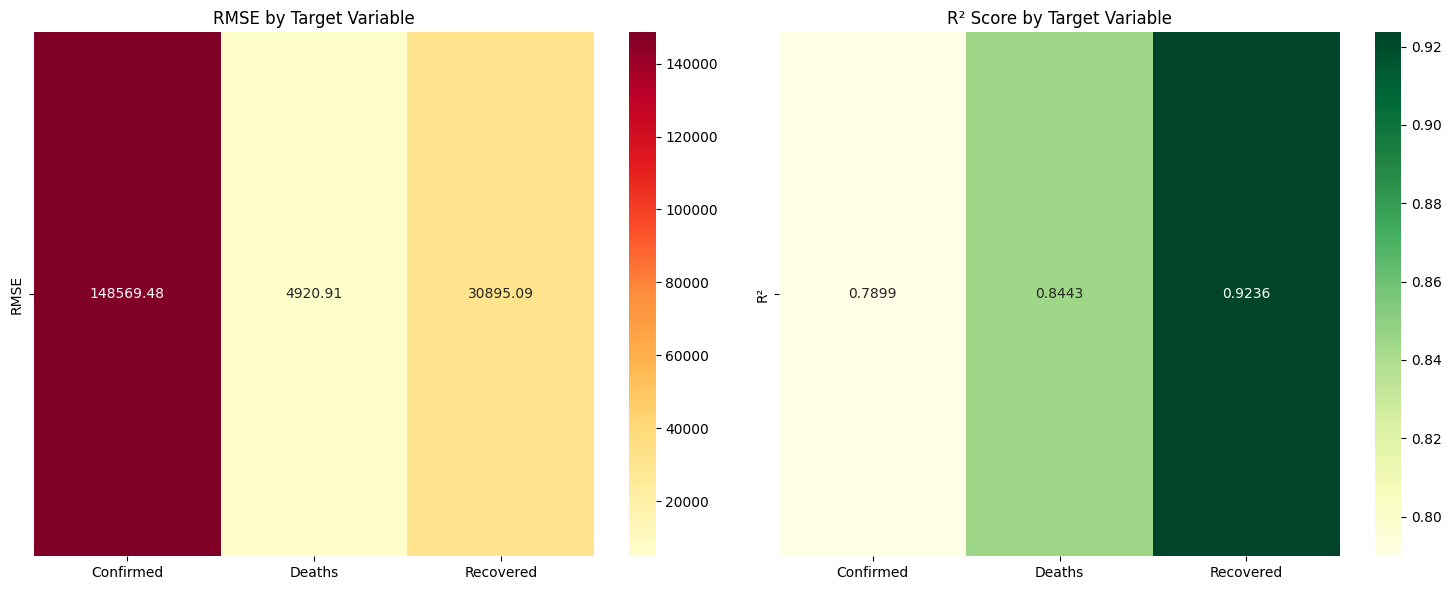

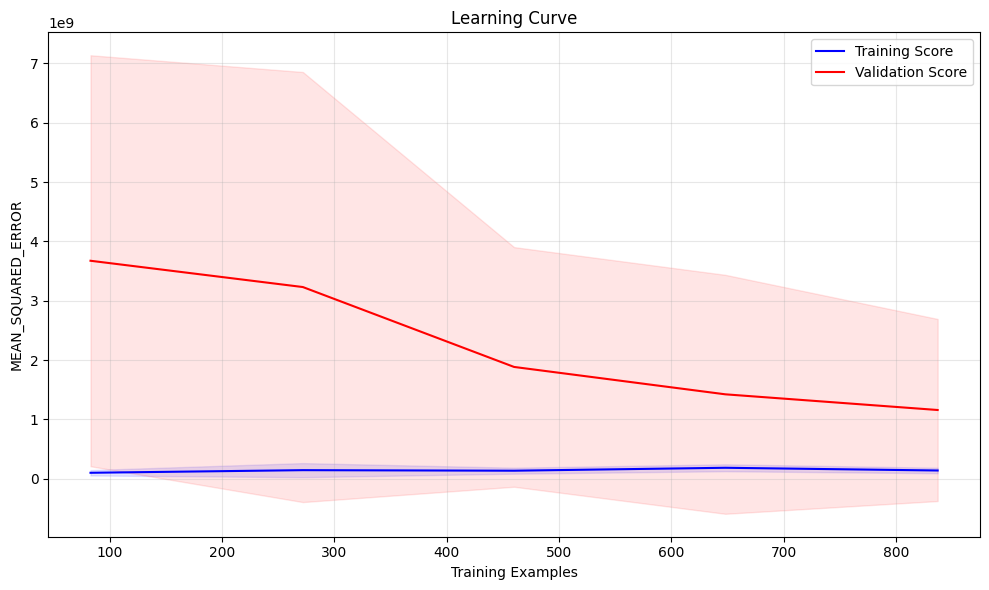

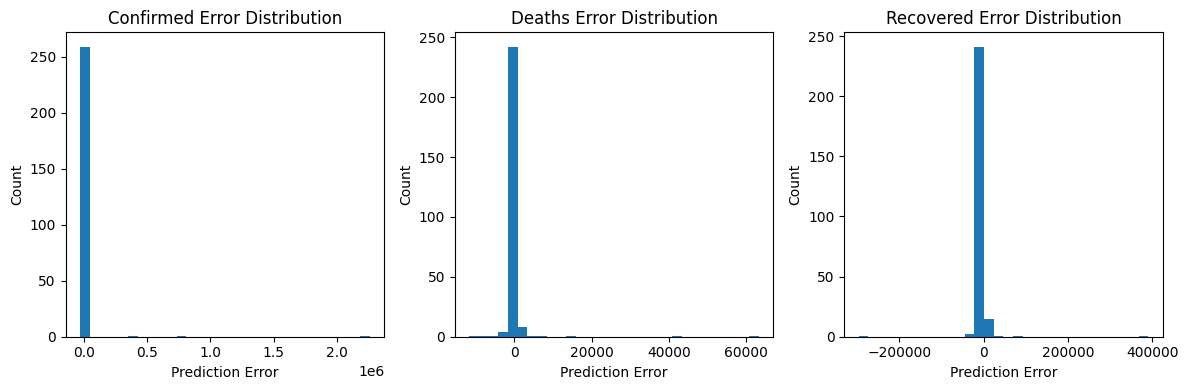

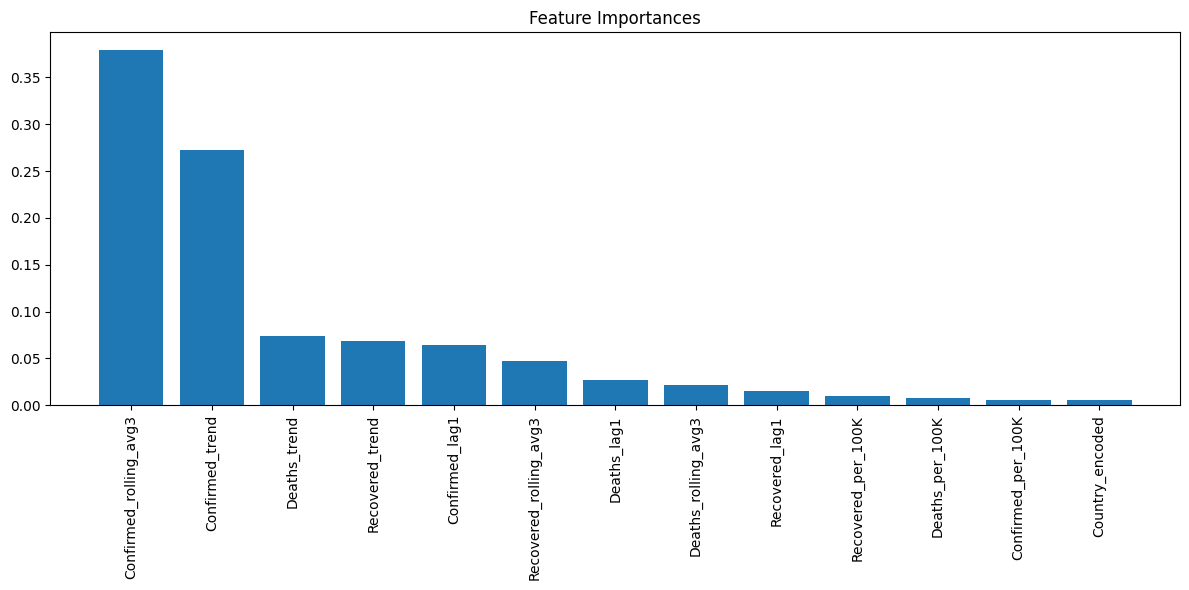

In [39]:
y_pred = rfr_model.predict(X_test)
outputs = ['Confirmed', 'Deaths', 'Recovered']

# For sklearn models, you might need to reshape y_pred if it's not already 2D
plot_performance_metrics(y_test, y_pred, outputs)
plot_over_training(rfr_model, X_train, y_train, model_type='rf')
plot_error_distribution(y_test, y_pred, outputs)
plot_feature_importance(rfr_model, features)

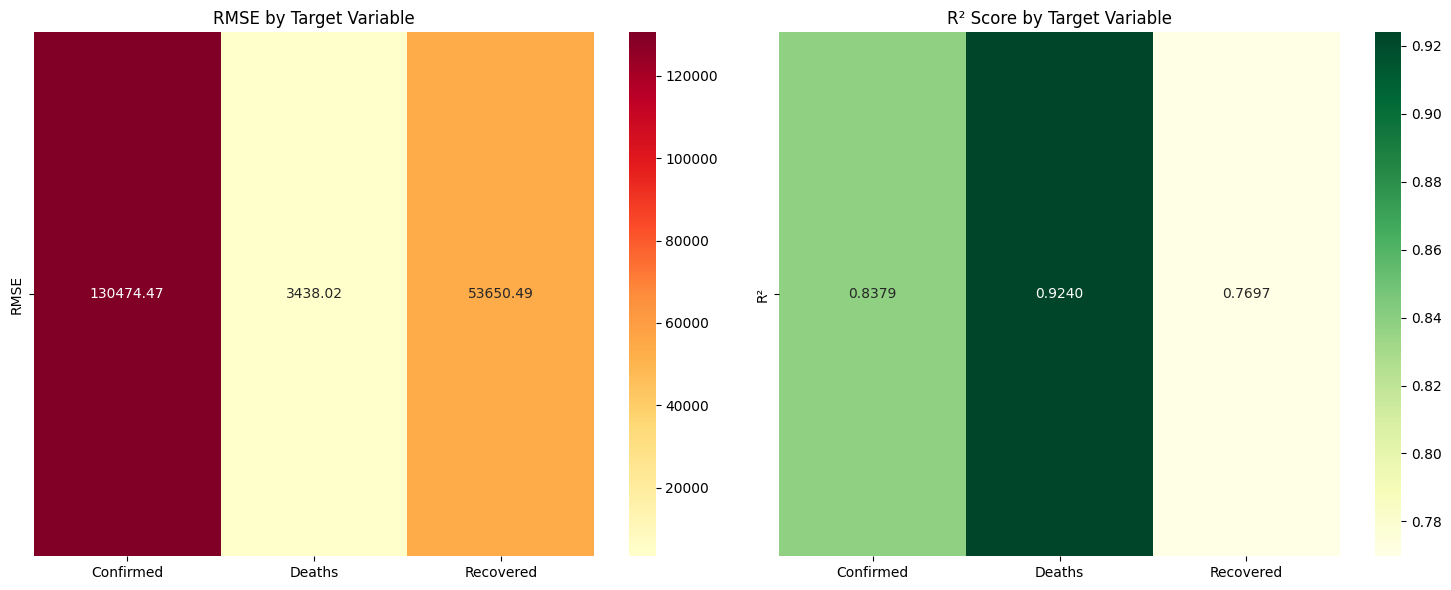

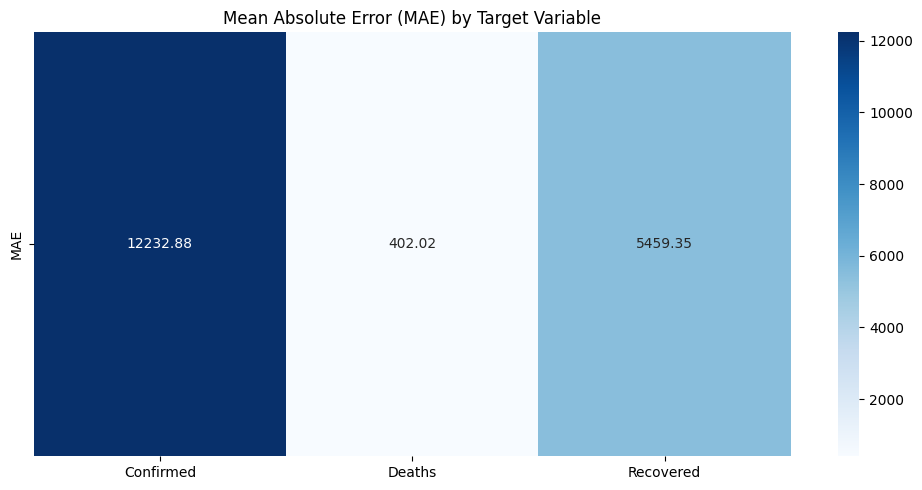

/tmp/ipykernel_53/1876462089.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0)


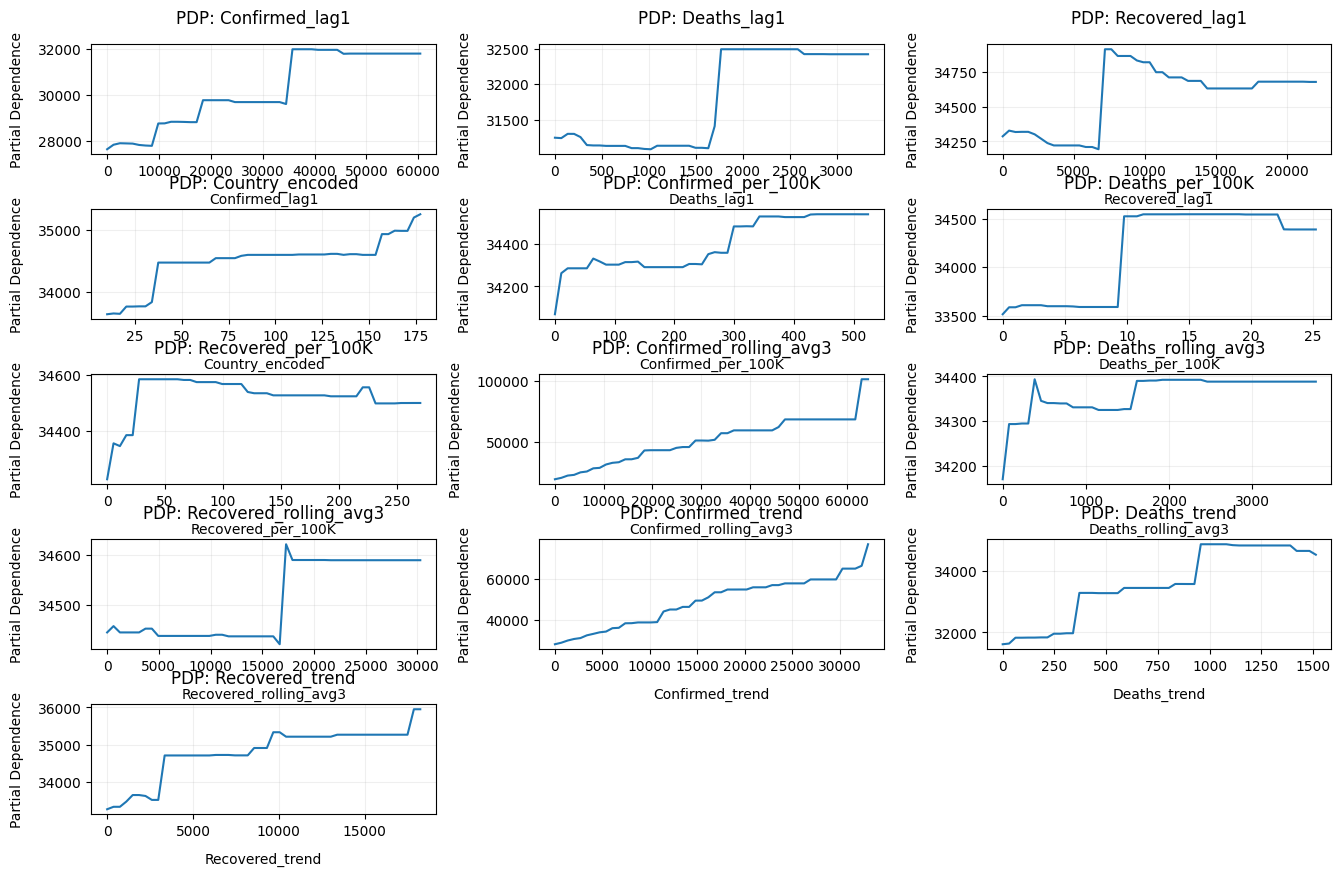

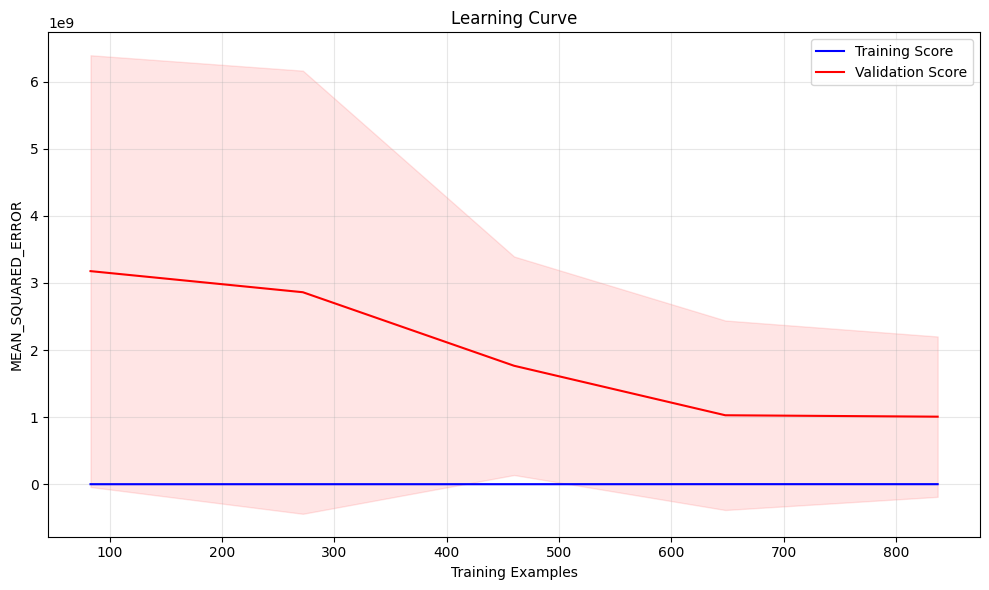

In [40]:
y_pred = xgb_model.predict(X_test)  # XGBoost outputs 2D arrays by default
outputs = ['Confirmed', 'Deaths', 'Recovered']
features = X_test.columns.tolist()  # List of feature names

plot_performance_metrics(y_test, y_pred, outputs)  # RMSE/R² heatmap
plot_mae_heatmap(y_test, y_pred, outputs)
plot_partial_dependence(xgb_model, X_test, features, target_idx=0)
plot_over_training(xgb_model, X_train, y_train, model_type='xgb')

9/9 [==============================] - 0s 1ms/step


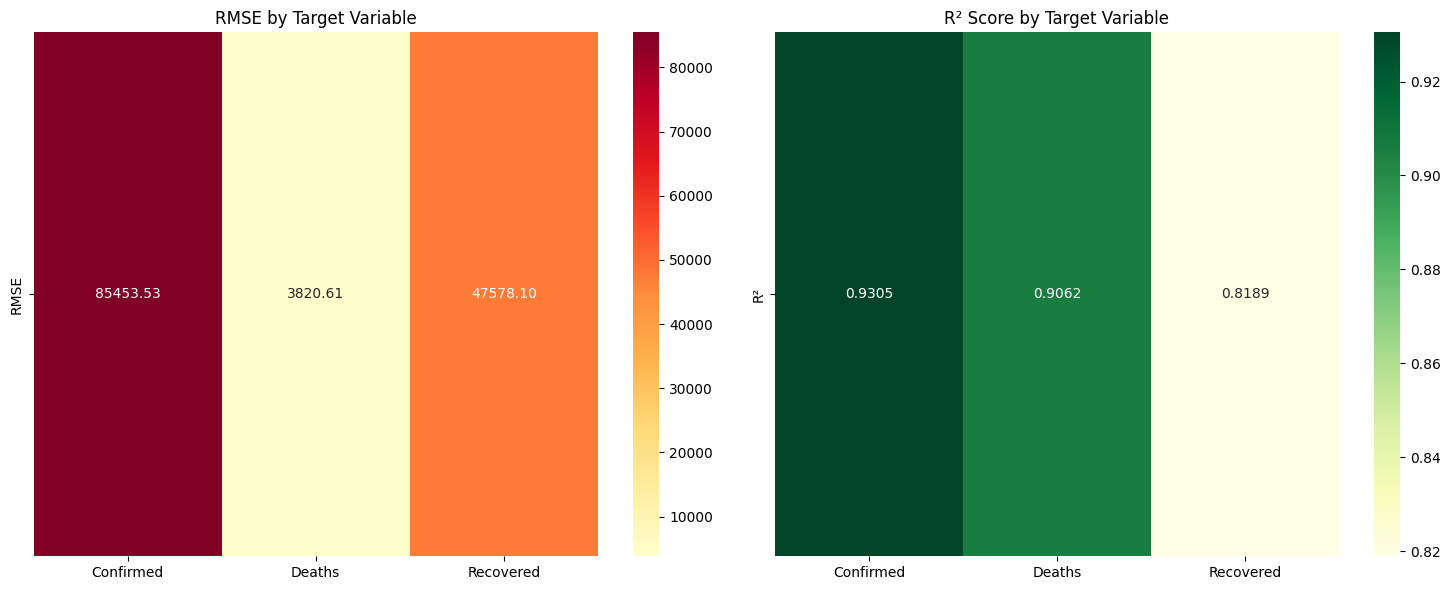

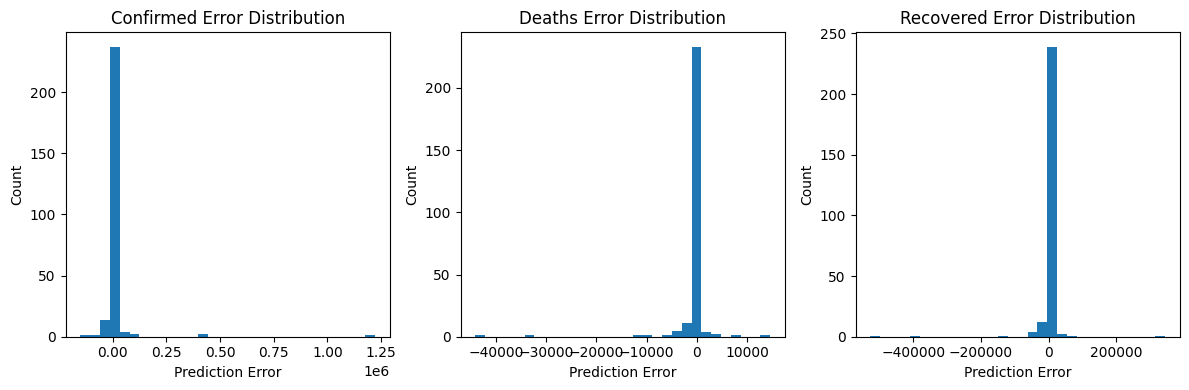

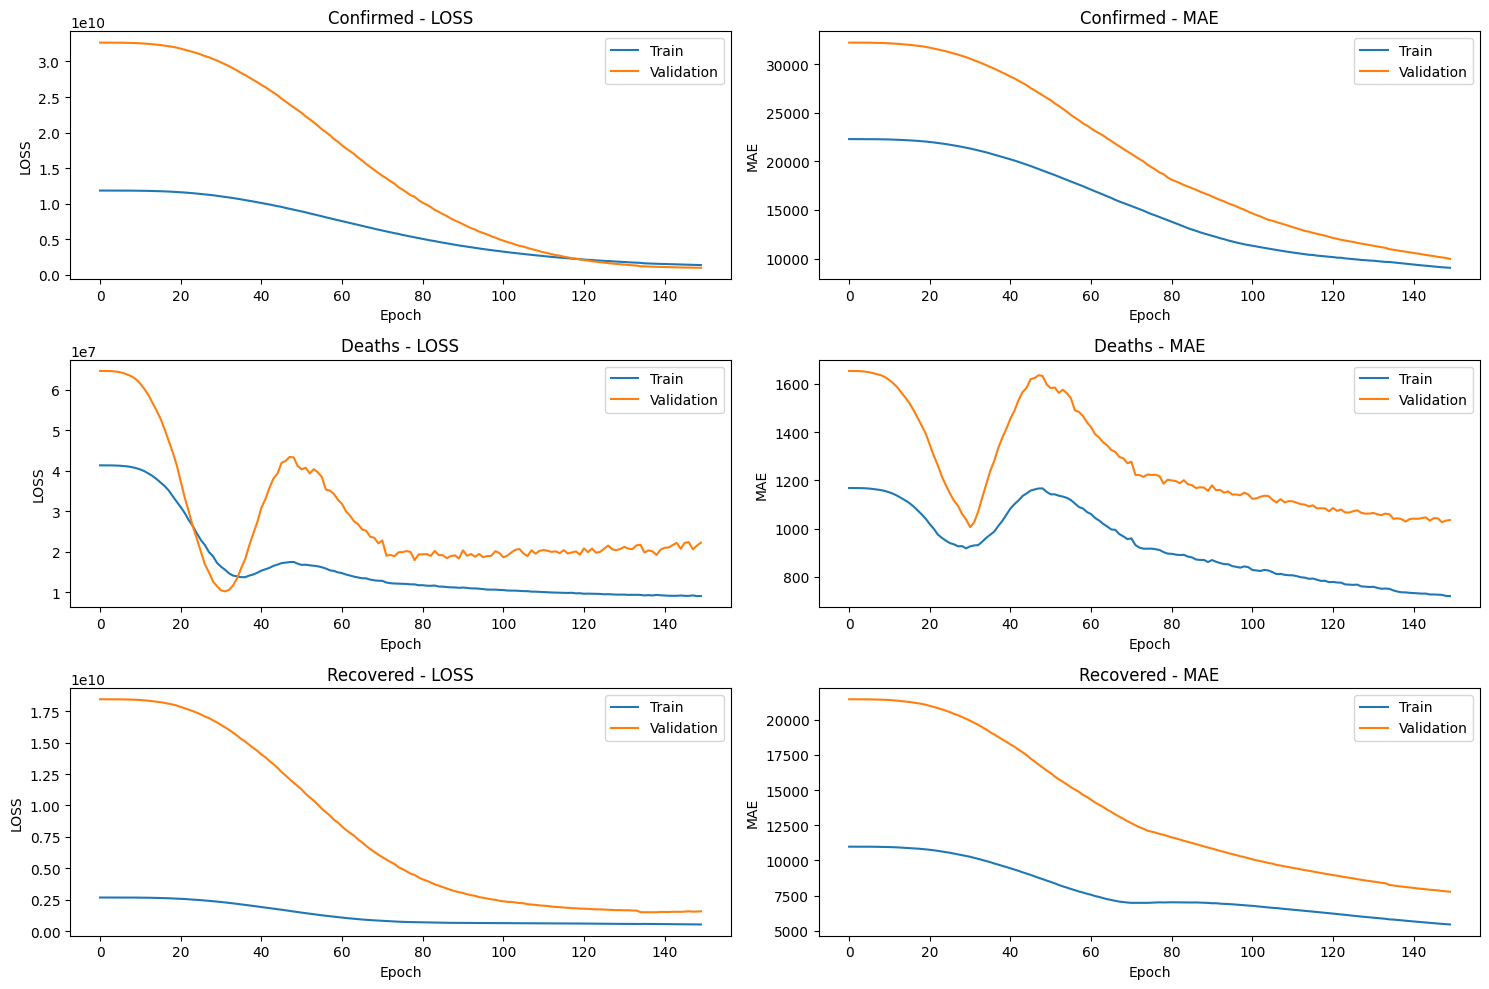

In [34]:
y_pred = keras_model.predict(X_test_scaled)
outputs = ['Confirmed', 'Deaths', 'Recovered']


plot_performance_metrics(y_test, y_pred, outputs)
plot_error_distribution(y_test, y_pred, outputs)
plot_training_history(history, outputs)

In [45]:
import mlflow
import tempfile
import os
from datetime import datetime

def log_plots_to_mlflow(model, X_test, y_test, features, outputs, model_type, history=None):
    """
    Log all relevant plots to MLflow for a given model.
    
    Args:
        model: Trained model
        X_test: Test features
        y_test: Test targets
        features: List of feature names
        outputs: List of output/target names
        model_type: 'rf', 'xgb', or 'keras'
        history: Training history (for Keras models)
    """
    # Create predictions
    if model_type == 'keras':
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)
    
    # Create a temporary directory for plots
    with tempfile.TemporaryDirectory() as tmp_dir:
        # Performance metrics
        plt.figure()
        plot_performance_metrics(y_test, y_pred, outputs)
        plt.savefig(os.path.join(tmp_dir, 'performance_metrics.png'))
        plt.close()
        
        # Error distribution
        plt.figure()
        plot_error_distribution(y_test, y_pred, outputs)
        plt.savefig(os.path.join(tmp_dir, 'error_distribution.png'))
        plt.close()
        
        # Training progress/learning curve
        plt.figure()
        if model_type == 'keras':
            plot_training_history(history, outputs)
        else:
            plot_over_training(model, X_test if model_type == 'xgb' else X_test, 
                             y_test, model_type=model_type)
        plt.savefig(os.path.join(tmp_dir, 'training_progress.png'))
        plt.close()
        
        # Model-specific plots
        if model_type in ['rf', 'xgb']:
            plt.figure()
            plot_feature_importance(model, features)
            plt.savefig(os.path.join(tmp_dir, 'feature_importance.png'))
            plt.close()
            
            if model_type == 'xgb':
                plt.figure()
                plot_partial_dependence(model, X_test, features, target_idx=0)
                plt.savefig(os.path.join(tmp_dir, 'partial_dependence.png'))
                plt.close()
        
        # Log all plots as artifacts
        mlflow.log_artifacts(tmp_dir, artifact_path="plots")

2025/07/02 08:34:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<Figure size 1500x600 with 0 Axes>

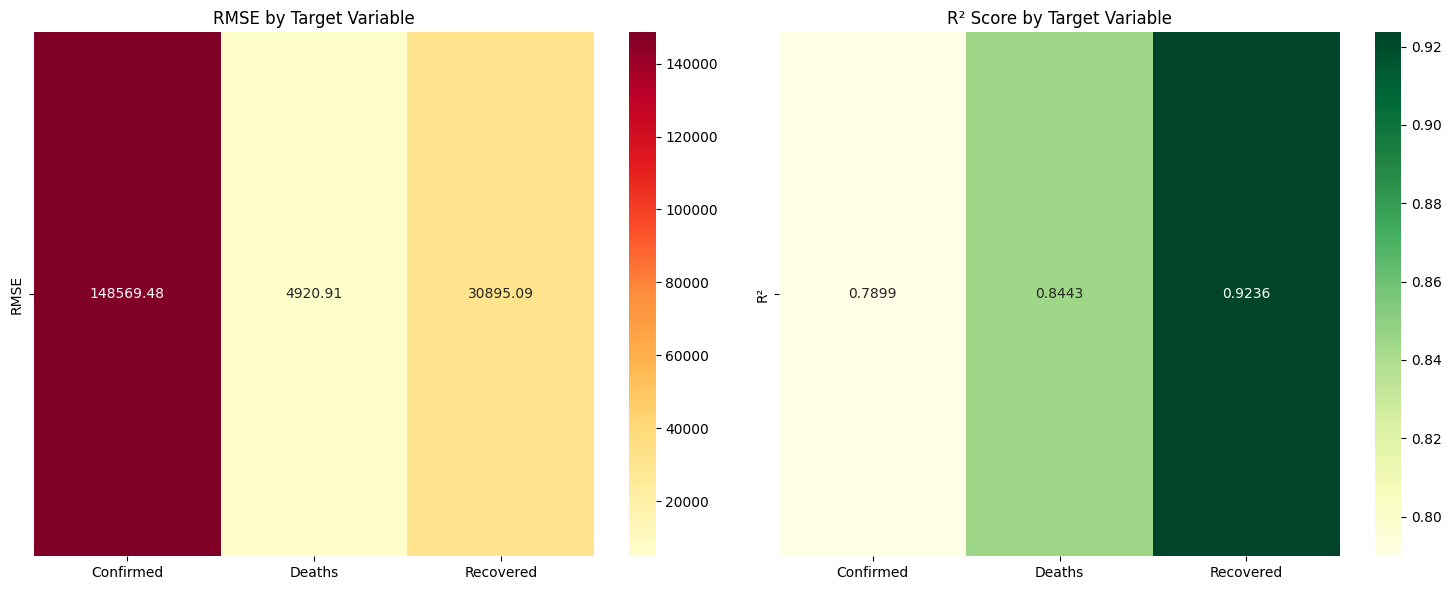

<Figure size 1200x400 with 0 Axes>

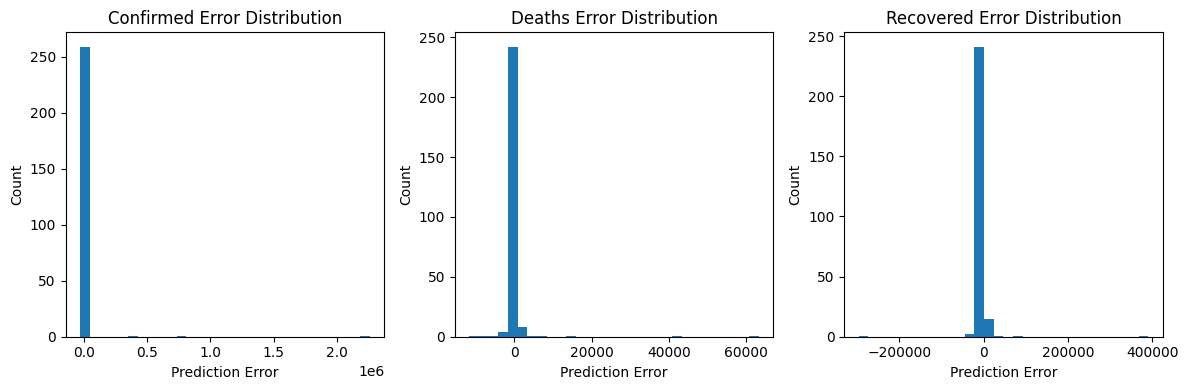

<Figure size 1200x600 with 0 Axes>

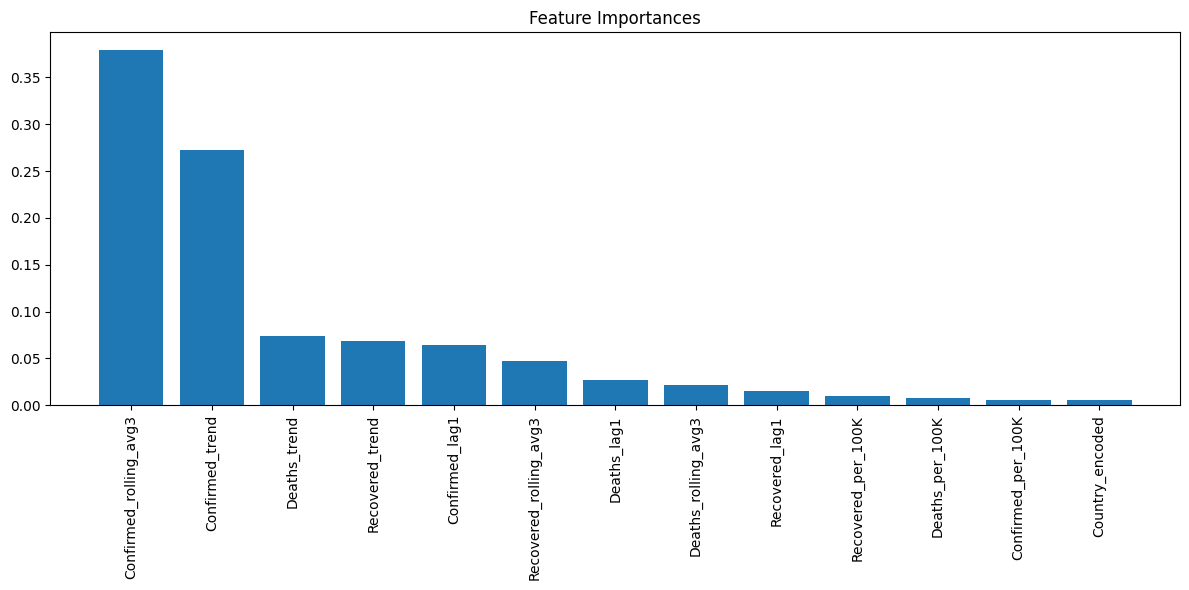

/usr/local/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [08:34:55] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/07/02 08:34:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<Figure size 1500x600 with 0 Axes>

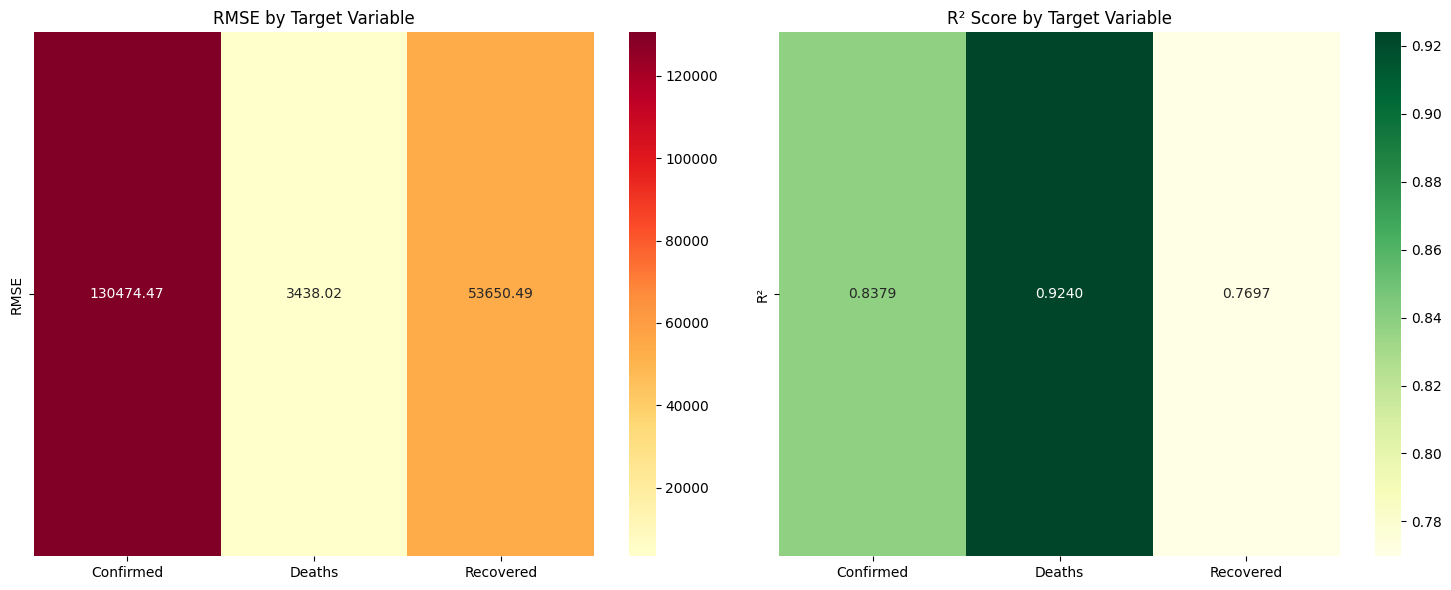

<Figure size 1200x400 with 0 Axes>

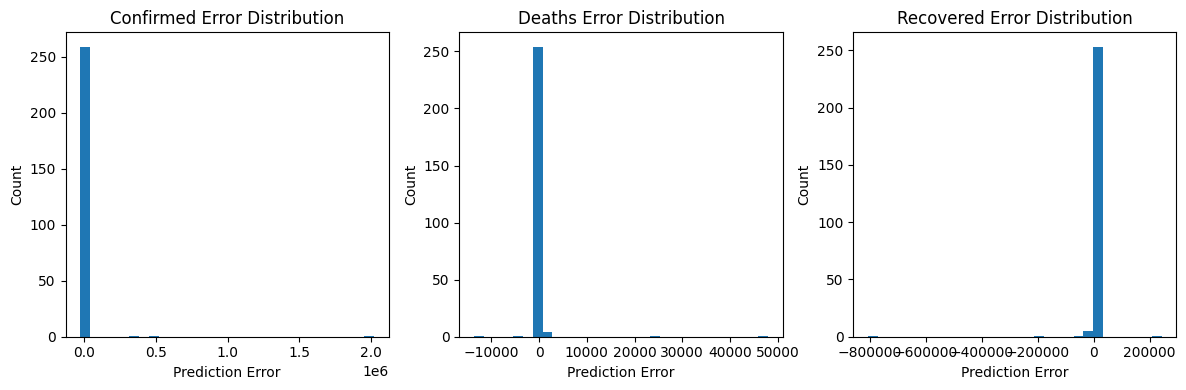

<Figure size 1200x600 with 0 Axes>

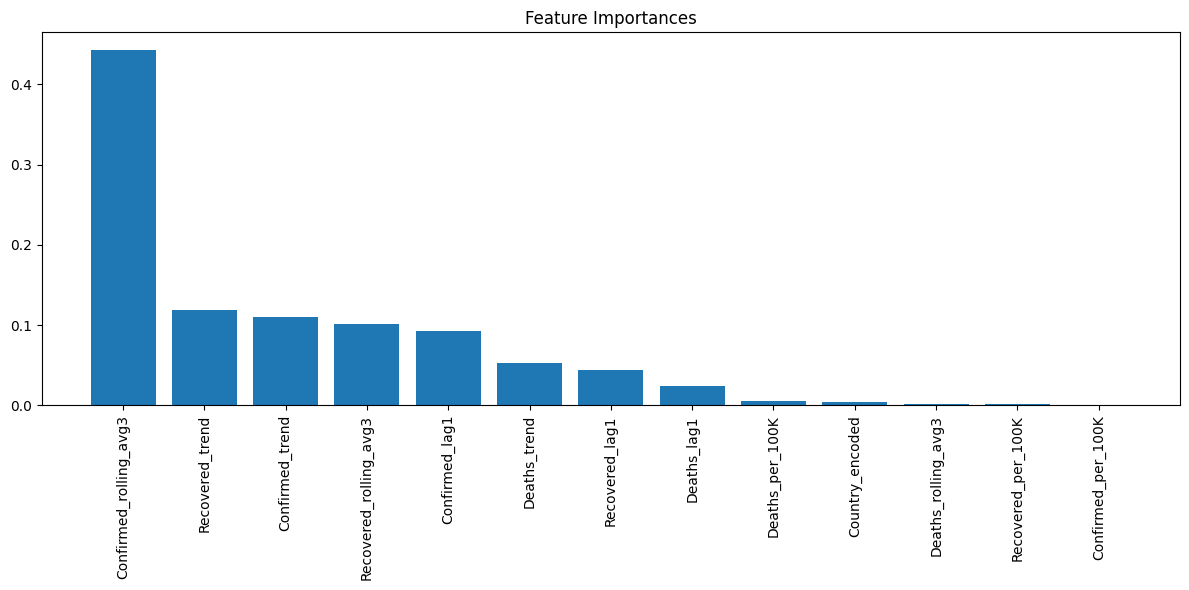

/tmp/ipykernel_53/1876462089.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0)


<Figure size 1600x1000 with 0 Axes>

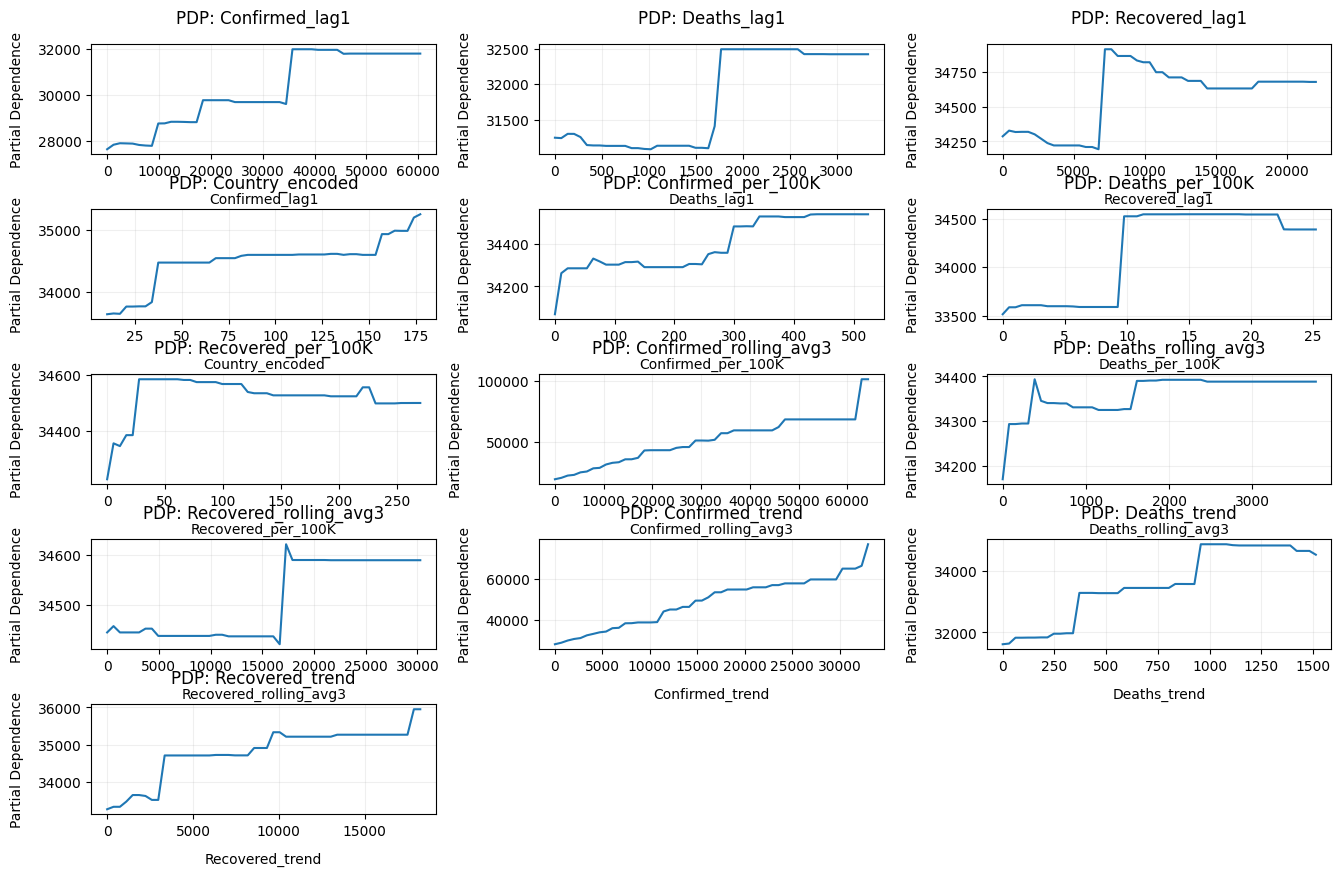

9/9 [==============================] - 0s 1ms/step


2025/07/02 08:35:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpbtxfy14c/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpbtxfy14c/model/data/model/assets
2025/07/02 08:35:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


<Figure size 1500x600 with 0 Axes>

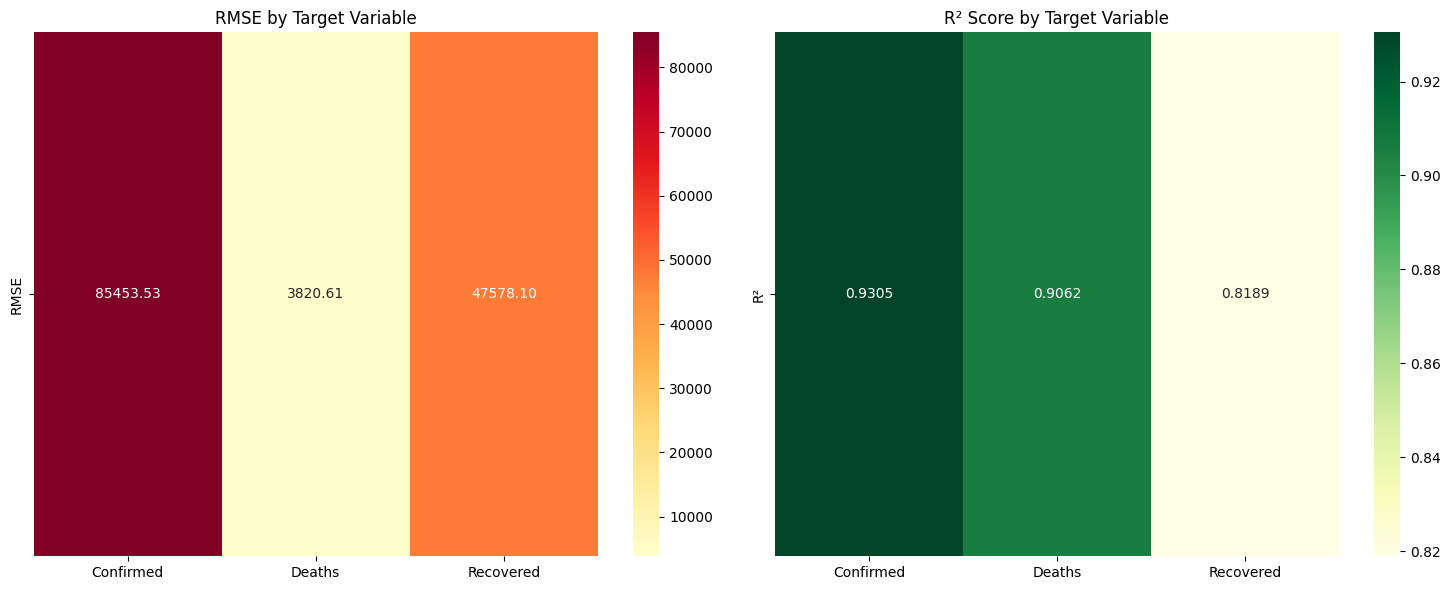

<Figure size 1200x400 with 0 Axes>

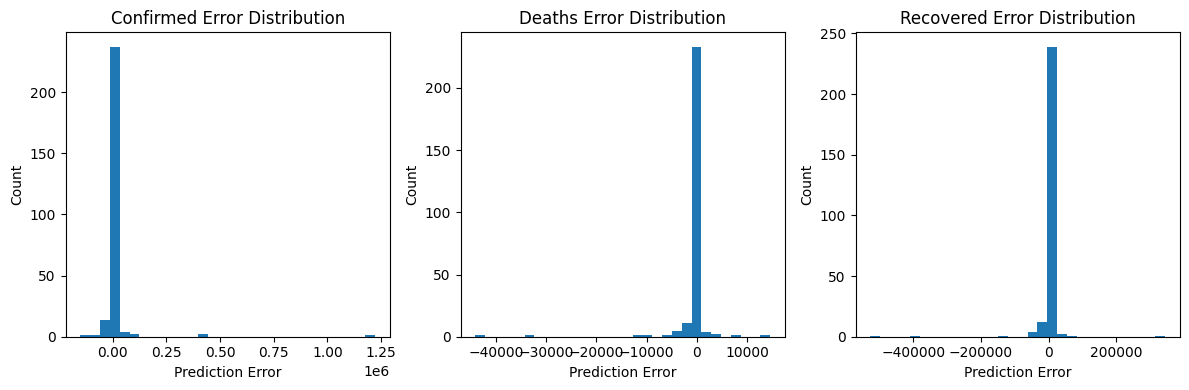

<Figure size 1500x1000 with 0 Axes>

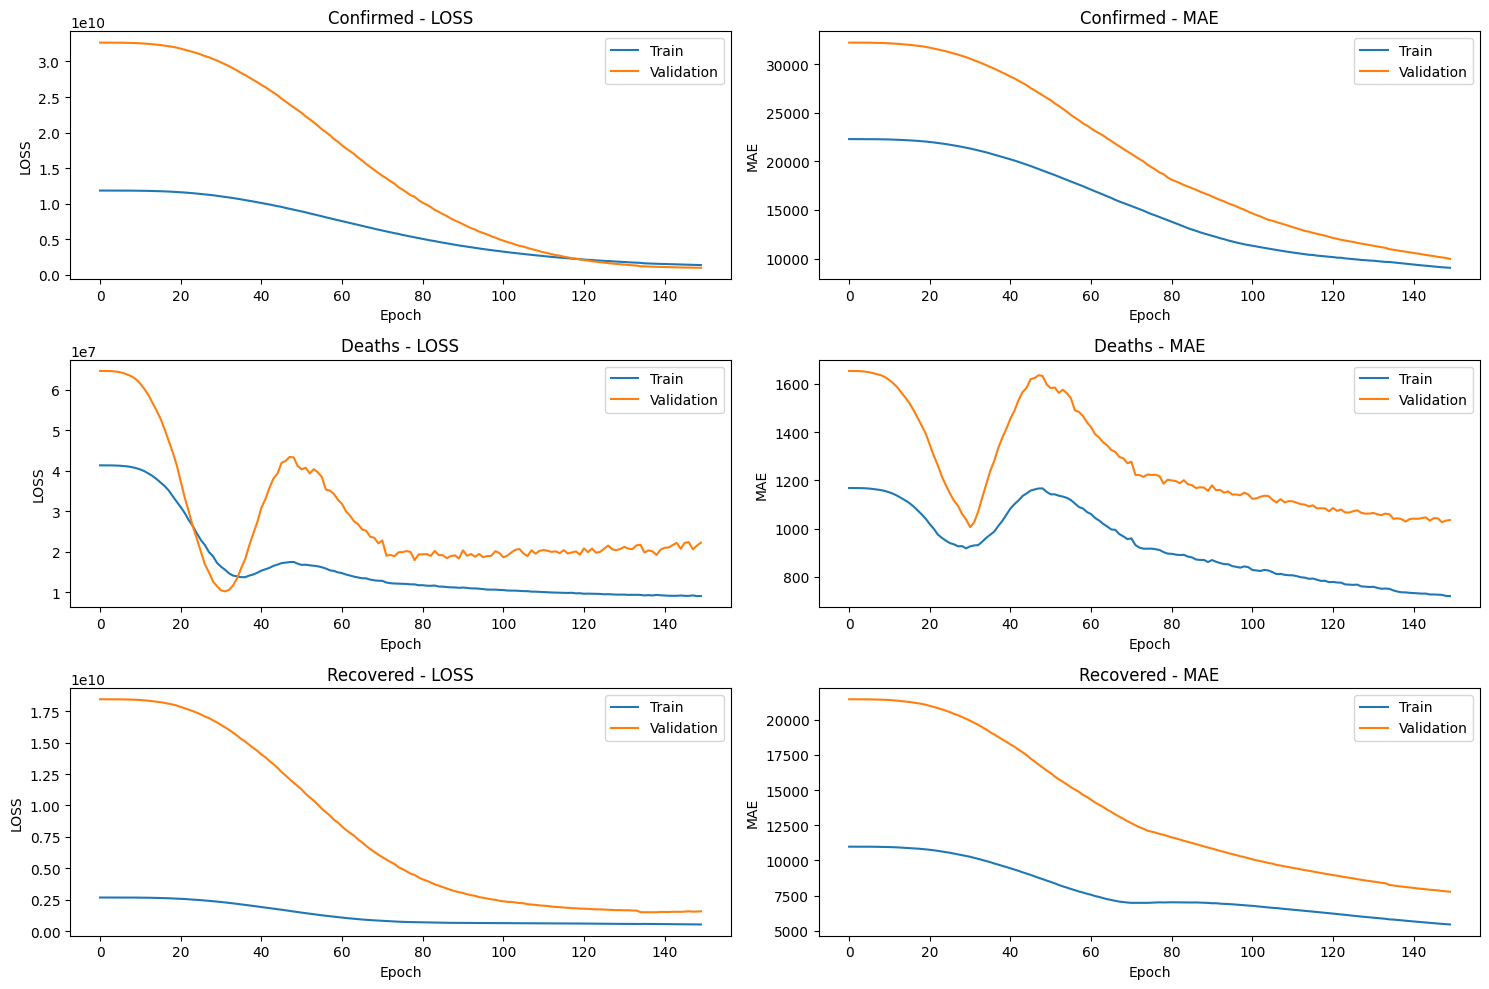

In [51]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.keras
import tempfile
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# Your existing plotting functions would be here
# [Include all your plotting functions from the original code]

def log_model_to_mlflow(model, model_name, model_type, X_test, y_test, features, outputs, params=None, metrics=None, history=None):
    """
    Complete MLflow logging for a trained model
    
    Args:
        model: Trained model object
        model_name: Name for the run
        model_type: 'rf', 'xgb', or 'keras'
        X_test: Test features
        y_test: Test targets
        features: List of feature names
        outputs: List of target names
        params: Dictionary of model parameters
        metrics: Dictionary of evaluation metrics
        history: Training history (for Keras)
    """
    # Start MLflow run
    with mlflow.start_run(run_name=f"{model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
        # Log parameters if provided
        if params:
            mlflow.log_params(params)
        
        # Generate predictions
        if model_type == 'keras':
            y_pred_list = model.predict(X_test)
            # Convert list of arrays to 2D array
            y_pred = np.column_stack(y_pred_list)
        else:
            y_pred = model.predict(X_test)
        
        # Calculate metrics if not provided
        if not metrics:
            metrics = {}
            for i, output in enumerate(outputs):
                true_values = y_test[output].values if hasattr(y_test, 'values') else y_test[:, i]
                metrics[f'rmse_{output}'] = np.sqrt(mean_squared_error(true_values, y_pred[:, i]))
                metrics[f'r2_{output}'] = r2_score(true_values, y_pred[:, i])
                metrics[f'mae_{output}'] = mean_absolute_error(true_values, y_pred[:, i])
        
        # Log metrics
        mlflow.log_metrics(metrics)
        
        # Log model
        if model_type == 'rf':
            mlflow.sklearn.log_model(model, "random_forest_model")
        elif model_type == 'xgb':
            mlflow.xgboost.log_model(model, "xgboost_model")
        elif model_type == 'keras':
            mlflow.keras.log_model(model, "keras_model")
        
        # Create and log plots
        with tempfile.TemporaryDirectory() as tmp_dir:
            # Performance metrics
            plt.figure(figsize=(15, 6))
            plot_performance_metrics(y_test, y_pred, outputs)
            plt.savefig(os.path.join(tmp_dir, 'performance_metrics.png'), bbox_inches='tight')
            plt.close()
            
            # Error distribution
            plt.figure(figsize=(12, 4))
            plot_error_distribution(y_test, y_pred, outputs)
            plt.savefig(os.path.join(tmp_dir, 'error_distribution.png'), bbox_inches='tight')
            plt.close()
            
            # Model-specific plots
            if model_type in ['rf', 'xgb']:
                plt.figure(figsize=(12, 6))
                plot_feature_importance(model, features)
                plt.savefig(os.path.join(tmp_dir, 'feature_importance.png'), bbox_inches='tight')
                plt.close()
                
                if model_type == 'xgb':
                    plt.figure(figsize=(16, 10))
                    plot_partial_dependence(model, X_test, features, target_idx=0)
                    plt.savefig(os.path.join(tmp_dir, 'partial_dependence.png'), bbox_inches='tight')
                    plt.close()
            
            if model_type == 'keras' and history:
                plt.figure(figsize=(15, 10))
                plot_training_history(history, outputs)
                plt.savefig(os.path.join(tmp_dir, 'training_history.png'), bbox_inches='tight')
                plt.close()
            
            # Log all plots as artifacts
            mlflow.log_artifacts(tmp_dir, artifact_path="plots")
        
        # Add tags
        mlflow.set_tag("model_type", model_type)
        mlflow.set_tag("targets", ", ".join(outputs))
        mlflow.set_tag("version", "V3")

def log_all_models_to_mlflow(rfr_model, xgb_model, keras_model, history, 
                           X_test, y_test, features, outputs):
    """
    Log all three models to MLflow in the COVID-19_Predictions_V3 experiment
    """
    # Setup MLflow experiment
    mlflow.set_experiment("COVID-19_Predictions_V3")
    
    # Log Random Forest model
    log_model_to_mlflow(
        model=rfr_model,
        model_name="Random_Forest",
        model_type='rf',
        X_test=X_test,
        y_test=y_test,
        features=features,
        outputs=outputs,
        params={
            'n_estimators': rfr_model.n_estimators,
            'max_depth': rfr_model.max_depth,
            'random_state': rfr_model.random_state
        }
    )
    
    # Log XGBoost model
    log_model_to_mlflow(
        model=xgb_model,
        model_name="XGBoost",
        model_type='xgb',
        X_test=X_test,
        y_test=y_test,
        features=features,
        outputs=outputs,
        params={
            'learning_rate': xgb_model.learning_rate,
            'n_estimators': xgb_model.n_estimators,
            'max_depth': xgb_model.max_depth
        }
    )
    
    # Log Keras model
    log_model_to_mlflow(
        model=keras_model,
        model_name="Keras_NN",
        model_type='keras',
        X_test=X_test_scaled,
        y_test=y_test,
        features=features,
        outputs=outputs,
        history=history,
        params={
            'epochs': 150,
            'batch_size': 32
        }
    )

# Example usage (assuming you have these variables already defined from your training)
log_all_models_to_mlflow(
    rfr_model=rfr_model,
    xgb_model=xgb_model,
    keras_model=keras_model,
    history=history,
    X_test=X_test,
    y_test=y_test,
    features=features,
    outputs=['Confirmed', 'Deaths', 'Recovered']
)